In [226]:
import pandas as pd
import numpy as np
import matplotlib as mp
import lightgbm as lgb
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, recall_score, accuracy_score, auc, classification_report, \
                            confusion_matrix, plot_confusion_matrix, precision_recall_curve, \
                            plot_precision_recall_curve, roc_curve, plot_roc_curve)

In [227]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import (roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, \
                             classification_report, plot_confusion_matrix, recall_score, \
                             plot_precision_recall_curve, precision_recall_curve, plot_roc_curve)

In [228]:
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [229]:
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [230]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [231]:
test = pd.read_csv('C:/Users/Anatoly/Desktop/Тестовое задание LICARD DS/DATA/contest_test.csv')

In [232]:
train = pd.read_csv('C:/Users/Anatoly/Desktop/Тестовое задание LICARD DS/DATA/contest_train.csv')

In [233]:
def clean_input(data) -> pd.DataFrame:
    """
    Перевод названий колонок в нижний регистр и вывод основной информации о наборе данных

    Parameters
    ----------
    data: Pandas DataFrame

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    #base_path = "data"
    #data = pd.read_csv(f"{base_path}/{data_path}")
    # Приводим все названия колонок к нижнему регистру
    data.columns = [col.lower() for col in data.columns]
    #print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
    print(f"shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [234]:
train = clean_input(train)
test = clean_input(test)

shape = 18390 rows, 262 cols
shape = 6131 rows, 261 cols


## Удаление лишних столбцов

In [235]:
numerical_features = train.select_dtypes(include=[np.number])

In [236]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 50


In [237]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature + ["ID"]]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 212


In [238]:
train_con = train[continuous_feature]

In [239]:
test_con = test[continuous_feature]

In [240]:
train_descr = train[discrete_feature]

In [241]:
test_descr = test[continuous_feature]

In [242]:
feature_0 = []

for feat in numerical_features: 
    if (len(train[feat].unique()) == 1) and (len(test[feat].unique()) == 1) and (train[feat].unique() == 0): 
        feature_0.append(feat)

In [243]:
feature_0

['feature_3', 'feature_144', 'feature_249', 'feature_256']

In [244]:
# Также отберем и впоследствии удалим те бинарные фичи (0-1), в которых отношение нулевых признаков к единичным более 90%

In [245]:
threshold = train.shape[0]*0.9

In [246]:
threshold

16551.0

In [247]:
feature_90 = []

In [248]:
for feat in discrete_feature:
    try:
        if train_descr[feat].value_counts()[0] > threshold: 
            feature_90.append(feat) 
    except KeyError as ke: 
        continue

In [249]:
feature_90 = list(set(feature_90))

In [250]:
feature_90 

['feature_6',
 'feature_256',
 'feature_5',
 'feature_157',
 'feature_140',
 'feature_2',
 'feature_31',
 'feature_32',
 'feature_144',
 'feature_159',
 'feature_249',
 'feature_3',
 'feature_156',
 'feature_20']

In [251]:
for feat in continuous_feature:
    try:
        if train_con[feat].value_counts()[0] > threshold: 
            feature_90.append(feat) 
    except KeyError as ke: 
        continue

In [252]:
feature_90 

['feature_6',
 'feature_256',
 'feature_5',
 'feature_157',
 'feature_140',
 'feature_2',
 'feature_31',
 'feature_32',
 'feature_144',
 'feature_159',
 'feature_249',
 'feature_3',
 'feature_156',
 'feature_20',
 'feature_22',
 'feature_25',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_75',
 'feature_139',
 'feature_141',
 'feature_145',
 'feature_146',
 'feature_176',
 'feature_200',
 'feature_201',
 'feature_202',
 'feature_229',
 'feature_231',
 'feature_246']

In [253]:
similar_feature = [#"feature_209",
                  "feature_210", "feature_211", 
                  "feature_212", "feature_213", 
                  "feature_214"]
#or to delete?
# какой-то один признак нужно обязательно оставить. Например "feature_209"

In [254]:
train = train.drop(feature_90, axis=1)
test = test.drop(feature_90, axis=1)

In [255]:
train = train.drop(similar_feature, axis=1)
test = test.drop(similar_feature, axis=1)

In [256]:
train.shape, test.shape

((18390, 219), (6131, 218))

## Feature engineering

In [257]:
# Cнова взглянем на обновленный датасет. 

In [338]:
# Раскомментируйте ячейку ниже для просмотра графиков фичей.

In [337]:
#for i in range(14):
#    fig, axes = plt.subplots(4, 4, figsize=(15, 15))

#    for num, feature in enumerate(train.iloc[:, i*16:(i+1)*16]):
#        data_train = train[feature].copy()
#        axes[num//4, num%4].hist(data_train, bins=25)
#        axes[num//4, num%4].set_xlabel(feature, fontsize=12)

In [262]:
#Бросается в глаза наличие большого кол-ва дублей. Надо найти способ как их удалить.
#Есть и лог-норальные распределения. Видны выбросы. Подумать, что с ними делать

## Признаки к удалению (без смысловой нагрузки)

In [267]:
list_16_19 = [15, 16, 18, 19, 76, 151, 152, 184, 234, 241, 245, 247]

In [268]:
for ind in list_16_19: 
    print(train[f'feature_{ind}'].value_counts(normalize=True))

0.0    0.873083
1.0    0.126917
Name: feature_15, dtype: float64
0.0    0.876291
1.0    0.123709
Name: feature_16, dtype: float64
0.0    0.883034
1.0    0.116966
Name: feature_18, dtype: float64
0.0    0.876563
1.0    0.123437
Name: feature_19, dtype: float64
0.000000     0.415334
0.032258     0.130614
0.064516     0.063078
0.096774     0.049973
0.129032     0.034856
               ...   
31.290323    0.000054
0.266667     0.000054
10.258065    0.000054
11.645161    0.000054
0.833333     0.000054
Name: feature_76, Length: 404, dtype: float64
0.0     0.945551
1.0     0.047265
2.0     0.006459
3.0     0.000362
4.0     0.000241
18.0    0.000060
5.0     0.000060
Name: feature_151, dtype: float64
0.0     0.938428
1.0     0.053181
2.0     0.006882
3.0     0.000845
4.0     0.000362
6.0     0.000121
24.0    0.000060
46.0    0.000060
5.0     0.000060
Name: feature_152, dtype: float64
1.0     0.953235
2.0     0.019956
3.0     0.009679
4.0     0.004187
5.0     0.002828
6.0     0.002175
7.0     0.

`Вывод`: удалить признаки из листа. Оставить хотя бы один (например номер 17)

In [269]:
feature_16_19_list = ['feature_'+str(i) for i in list_16_19]

In [270]:
feature_16_19_list

['feature_15',
 'feature_16',
 'feature_18',
 'feature_19',
 'feature_76',
 'feature_151',
 'feature_152',
 'feature_184',
 'feature_234',
 'feature_241',
 'feature_245',
 'feature_247']

In [271]:
train = train.drop(feature_16_19_list, axis=1)
test = test.drop(feature_16_19_list, axis=1)

In [272]:
train.shape, test.shape

((18390, 207), (6131, 206))

## features_187-192

<AxesSubplot:xlabel='feature_187', ylabel='Density'>

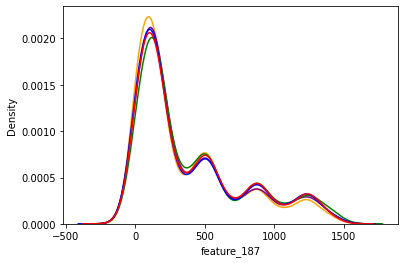

In [273]:
sns.kdeplot(train['feature_187'], color='orange')
sns.kdeplot(train['feature_190'], color='purple')
sns.kdeplot(train['feature_191'], color='green')
sns.kdeplot(train['feature_193'], color='blue')
sns.kdeplot(train['feature_192'], color='red')

In [274]:
train_187_192 = train[['feature_187', 'feature_190', 'feature_191', 'feature_192', 'feature_193']]

In [275]:
cor_1 = train_187_192.corr()

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

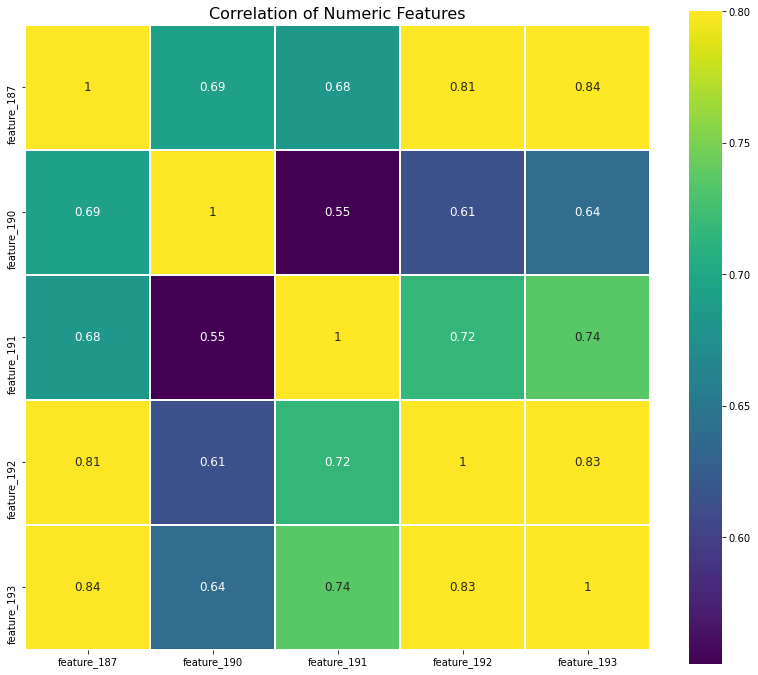

In [276]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features", y=1, size=16)
sns.heatmap(cor_1,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    annot_kws = {"size": 12}
)

In [277]:
train = train.drop(['feature_190', 'feature_191', 'feature_192', 'feature_193'], axis=1)
test = test.drop(['feature_190', 'feature_191', 'feature_192', 'feature_193'], axis=1)

In [278]:
#оставили фичу 187
train.shape, test.shape

((18390, 203), (6131, 202))

## features_127-138

In [279]:
train_127_138 = train[['feature_127', 'feature_128', 'feature_129', 'feature_130', 'feature_131', 
                      'feature_132', 'feature_133', 'feature_134', 'feature_135', 'feature_136', 
                      'feature_137', 'feature_138']]

In [280]:
cor_2 = train_127_138.corr()

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

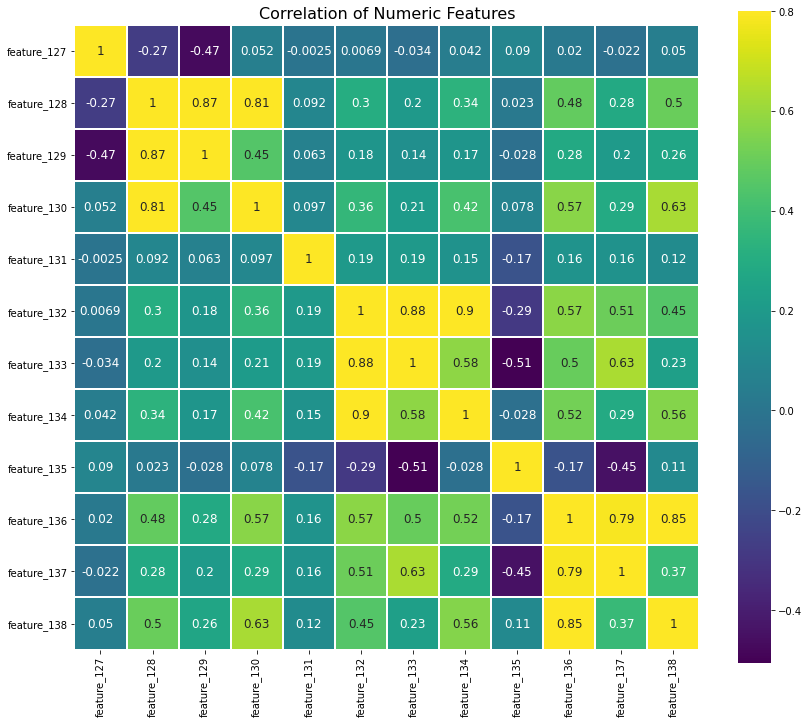

In [281]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features", y=1, size=16)
sns.heatmap(cor_2,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    annot_kws = {"size": 12}
)

In [282]:
#интересная картина - два признака очень сильно между собой коррелируют, а третий из этого квадрата коррелируют только с первым.

<AxesSubplot:xlabel='feature_128', ylabel='Density'>

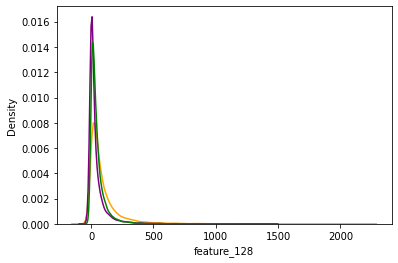

In [284]:
sns.kdeplot(train['feature_128'], color='orange')
sns.kdeplot(train['feature_129'], color='purple')
sns.kdeplot(train['feature_130'], color='green')

<AxesSubplot:xlabel='feature_132', ylabel='Density'>

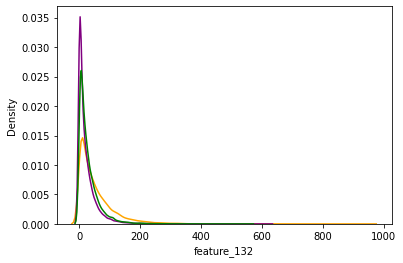

In [285]:
sns.kdeplot(train['feature_132'], color='orange')
sns.kdeplot(train['feature_133'], color='purple')
sns.kdeplot(train['feature_134'], color='green')

<AxesSubplot:xlabel='feature_136', ylabel='Density'>

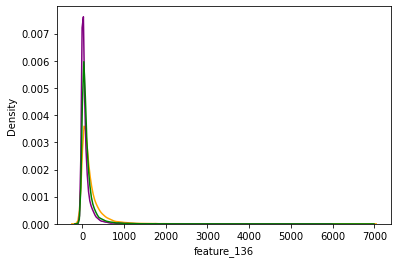

In [286]:
sns.kdeplot(train['feature_136'], color='orange')
sns.kdeplot(train['feature_137'], color='purple')
sns.kdeplot(train['feature_138'], color='green')

In [287]:
# удаляем 132, 128, 136

In [288]:
train = train.drop(['feature_132', 'feature_128', 'feature_136'], axis=1)
test = test.drop(['feature_132', 'feature_128', 'feature_136'], axis=1)

## features_45-52

In [289]:
train_45_52 = train[['feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 
                      'feature_50', 'feature_51', 'feature_52']]

In [290]:
cor_3 = train_45_52.corr()

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

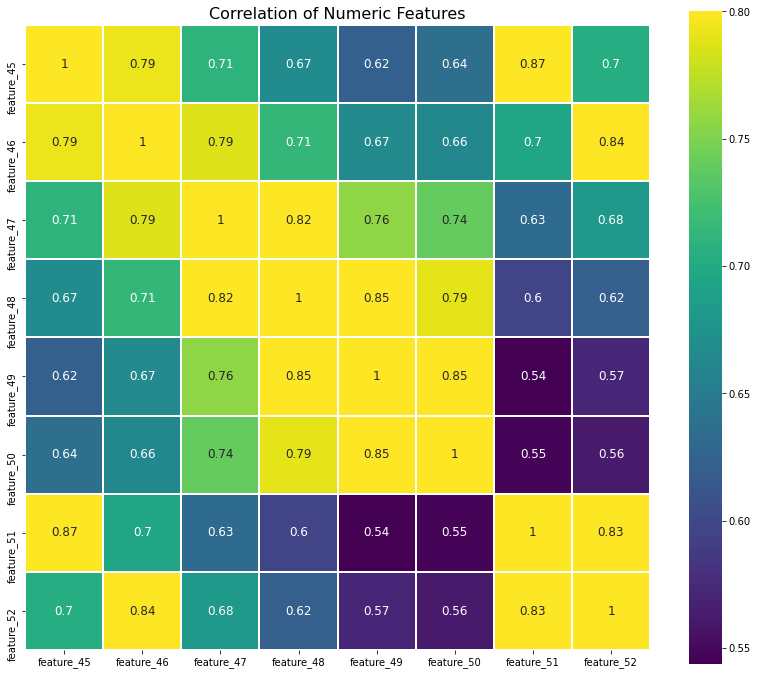

In [291]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features", y=1, size=16)
sns.heatmap(cor_3,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    annot_kws = {"size": 12}
)

In [292]:
# очень красивая линейная корреляция! 

<AxesSubplot:xlabel='feature_45', ylabel='Density'>

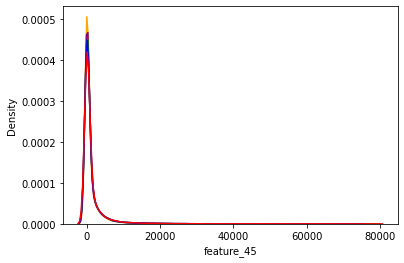

In [293]:
sns.kdeplot(train['feature_45'], color='orange')
sns.kdeplot(train['feature_46'], color='purple')
sns.kdeplot(train['feature_47'], color='green')
sns.kdeplot(train['feature_48'], color='blue')
sns.kdeplot(train['feature_49'], color='red')

In [294]:
# как собственно и тут - все задублировалось. 

In [296]:
train = train.drop(['feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_51', 'feature_52'], axis=1)
test = test.drop(['feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_51', 'feature_52'], axis=1)

In [297]:
train.shape, test.shape

((18390, 194), (6131, 193))

In [ ]:
# Можно попробовать как вариант применить PCA/TSNE и объединить часть признаков в один. 

## features_33-38

In [299]:
train_33_38 = train[['feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 
                      'feature_38']]

<AxesSubplot:xlabel='feature_33', ylabel='Density'>

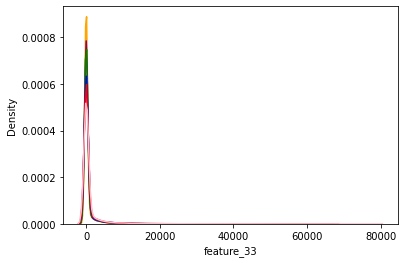

In [300]:
sns.kdeplot(train['feature_33'], color='orange')
sns.kdeplot(train['feature_34'], color='purple')
sns.kdeplot(train['feature_35'], color='green')
sns.kdeplot(train['feature_36'], color='blue')
sns.kdeplot(train['feature_37'], color='red')
sns.kdeplot(train['feature_38'], color='pink')

In [301]:
cor_4 = train_33_38.corr()

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

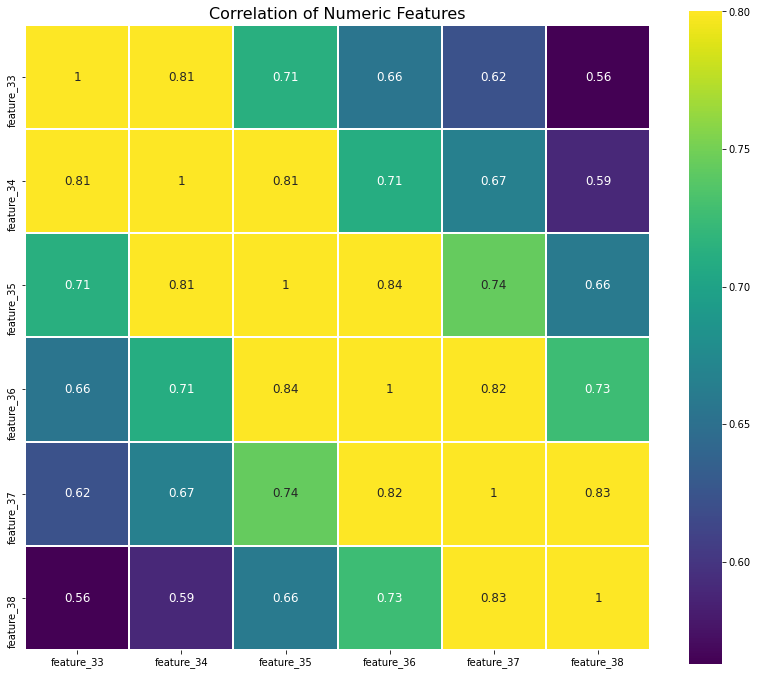

In [302]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features", y=1, size=16)
sns.heatmap(cor_4,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    annot_kws = {"size": 12}
)

In [303]:
# последовательная линейная зависимость.

In [304]:
train = train.drop(['feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38'], axis=1)
test = test.drop(['feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38'], axis=1)

## features_117-119

<AxesSubplot:xlabel='feature_117', ylabel='Density'>

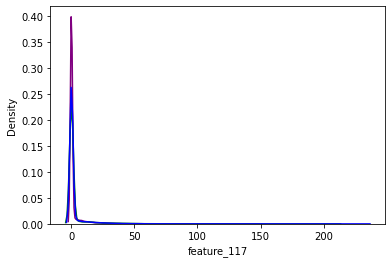

In [306]:
sns.kdeplot(train['feature_117'], color='purple')
sns.kdeplot(train['feature_118'], color='green')
sns.kdeplot(train['feature_119'], color='blue')

In [307]:
train_117_119 = train[['feature_117', 'feature_118', 'feature_119']]

In [311]:
cor_5 = train_117_119.corr()

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

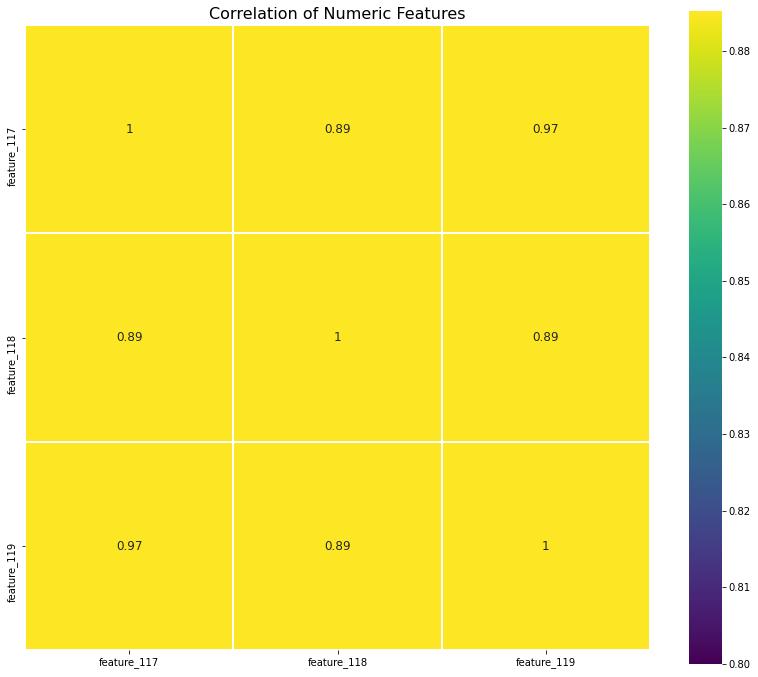

In [312]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features", y=1, size=16)
sns.heatmap(cor_5,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    annot_kws = {"size": 12}
)

In [313]:
# Линейная корреляция. Один оставляем. Два других - удаляем.

In [314]:
train = train.drop(['feature_118', 'feature_119'], axis=1)
test = test.drop(['feature_118', 'feature_119'], axis=1)

In [315]:
# list_149_248 = [149, 150, 151, 152, 153, 154, 155, 158, 172, 184, 197, 198, 224, 226, 234, 241, 245, 247, 248]
# for ind in list_149_248: 
#    print(train[f'feature_{ind}'].value_counts(normalize=True))
# под удаление = 151, 152, 184, 234, 241, 245, 247. Остальных в этом листе нужно будет исследовать распределение 
# value_counts() и убрать выбросы! 

In [316]:
target = train['target']

In [317]:
feat_to_drop = ['id', 'target']

In [318]:
train = train.drop(feat_to_drop, axis=1)

In [319]:
test_id = test['id']

In [320]:
test = test.drop('id', axis=1)

In [321]:
train.shape, test.shape

((18390, 185), (6131, 185))

In [ ]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "MultiClass",
    "eval_metric": "TotalF1",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 5,
    "l2_leaf_reg": 25,
    #"early_stopping_rounds": 25,
    "thread_count": -1,
    "random_seed": 25
}

## Validation_method_1 - Hold out валидация

Или, проще говоря, валидация на __отложенной выборке__

In [453]:
data = train

In [454]:
x_train, x_valid = train_test_split(
    data, train_size=0.5, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    target, train_size=0.5, shuffle=True, random_state=1,
)


x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=42
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=42
)

In [455]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 9195 rows, 185 cols
x_valid.shape = 6436 rows, 185 cols
x_test.shape = 2759 rows, 185 cols


In [459]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "MultiClass",
    "eval_metric": "TotalF1",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 5,
    "l2_leaf_reg": 25,
    #"early_stopping_rounds": 25,
    "thread_count": -1,
    "random_seed": 25
}

In [460]:
train_pool = cb.Pool(x_train, y_train)
valid_pool = cb.Pool(x_valid, y_valid)

In [461]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5930807	test: 0.5860855	best: 0.5860855 (0)	total: 41.9ms	remaining: 41.9s
100:	learn: 0.6001152	test: 0.5916549	best: 0.5917441 (97)	total: 3.63s	remaining: 32.3s
200:	learn: 0.6112198	test: 0.6032944	best: 0.6033971 (193)	total: 6.64s	remaining: 26.4s
300:	learn: 0.6242027	test: 0.6097040	best: 0.6100098 (297)	total: 10s	remaining: 23.3s
400:	learn: 0.6371549	test: 0.6187532	best: 0.6193465 (382)	total: 13.5s	remaining: 20.1s
500:	learn: 0.6502408	test: 0.6228914	best: 0.6229123 (497)	total: 17.1s	remaining: 17s
600:	learn: 0.6595169	test: 0.6279302	best: 0.6279302 (600)	total: 22.1s	remaining: 14.7s
700:	learn: 0.6680598	test: 0.6313604	best: 0.6313804 (698)	total: 26.7s	remaining: 11.4s
800:	learn: 0.6760608	test: 0.6331160	best: 0.6335527 (799)	total: 30.6s	remaining: 7.6s
900:	learn: 0.6861672	test: 0.6345703	best: 0.6346050 (861)	total: 34.9s	remaining: 3.84s
999:	learn: 0.6939391	test: 0.6349798	best: 0.6350700 (995)	total: 39.1s	remaining: 0us

bestTest = 0.6350700

`Вывод:` мы получили прекрасный скор на валидации. __Но!__  

    1) У нас была всего одна итерация. Это очень-очень плохо. Модель могла просто недообучиться
    
    2) Валидация на отложенной выборке плохо работает с тремя классами. Тем более, что у нас они как мы помним, были несбалансированы
    
    3) Каким бы "вкусным" не был скор в 0.59 нам придется отказаться от этого метода, потому что он будет неустойчив при возникновении новых данных

In [462]:
score_valid = f1_score(y_valid, model_cb.predict(x_valid)[:, 0], average='macro')

In [463]:
score_valid

0.41870069530780146

In [464]:
score_test = f1_score(y_test, model_cb.predict(x_test)[:, 0], average='macro')

In [465]:
score_test

0.4548629332504608

In [466]:
# на тестовой валидной вышло чуть лучше. 0.45

In [467]:
y_pred = model_cb.predict(test)[:, 0]

In [468]:
y_pred = pd.DataFrame({
    "ID": test_id,
    "TARGET": y_pred 
    })

In [469]:
y_pred.to_csv('Lyutov_Anatoly_hold_out_1.csv', index=False, encoding='utf-8')

In [470]:
y_pred['TARGET'].value_counts()

0    5764
1     193
2     174
Name: TARGET, dtype: int64

## Crossvalidation (Stratify_Kfold)

Способ валидации очень похожий на KFold, только с небольшим дополнением. Разделение данных на фолды происходит так, чтобы в каждом фолде было __одинаковое распределение целевой переменной.__ Такой подход полезен, если у нас __слишком мало данных для обучения модели, а также для сильно несбалансированных наборов данных для задачи классификации. Кроме того, такой подход полезен при решении задачи многоклассовой классификации с большим количество классов.__

<img src="./web2_stratified_kfold.png" width=800 height=600 />

In [431]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    #X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict(x_valid)[:, 0]
        print(oof_preds)
        #oof_preds[valid_idx] = [np.argmax(line) for line in oof_preds[valid_idx]] 
        score = f1_score(y_valid, oof_preds[valid_idx], average='macro')
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(score)
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [471]:
cb_params = {
    "n_estimators": 1500,
    #"learning_rate": 0.01,
    "loss_function": "MultiClass",
    "eval_metric": "TotalF1",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 25,
    #"early_stopping_rounds": 100,
    "thread_count": -1,
    "random_seed": 42
}

In [472]:
cb_cv = StratifiedKFold(n_splits=5, random_state=128239, shuffle=True)

cb_estimators, cb_oof_preds = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cb_cv)

Thu Mar 17 22:54:06 2022, Cross-Validation, 18390 rows, 185 cols
0:	learn: 0.5936870	test: 0.5936870	test1: 0.5920755	best: 0.5920755 (0)	total: 118ms	remaining: 2m 56s
100:	learn: 0.6023808	test: 0.6023808	test1: 0.6032266	best: 0.6034080 (97)	total: 5.01s	remaining: 1m 9s
200:	learn: 0.6154368	test: 0.6154368	test1: 0.6115735	best: 0.6115735 (199)	total: 9.45s	remaining: 1m 1s
300:	learn: 0.6258132	test: 0.6258132	test1: 0.6230479	best: 0.6230479 (297)	total: 13.8s	remaining: 55s
400:	learn: 0.6372273	test: 0.6372273	test1: 0.6266864	best: 0.6267727 (397)	total: 18.1s	remaining: 49.7s
500:	learn: 0.6483976	test: 0.6483976	test1: 0.6305933	best: 0.6307510 (492)	total: 23.6s	remaining: 47.1s
600:	learn: 0.6570875	test: 0.6570875	test1: 0.6369199	best: 0.6369199 (600)	total: 29s	remaining: 43.4s
700:	learn: 0.6650714	test: 0.6650714	test1: 0.6391241	best: 0.6391241 (700)	total: 34.5s	remaining: 39.3s
800:	learn: 0.6722718	test: 0.6722718	test1: 0.6393990	best: 0.6400566 (750)	total: 39.

In [473]:
print(set(cb_oof_preds))

{0.0, 1.0, 2.0}


In [474]:
y_pred = np.zeros(test.shape[0])

In [475]:
estimators = cb_estimators
cv = cb_cv

for estimator in estimators:
    y_pred += estimator.predict(test)[:, 0]
    
y_pred = pd.DataFrame({
    "ID": test_id,
    "TARGET": y_pred / cb_cv.n_splits
})

In [476]:
y_pred["TARGET"].value_counts()

0.0    5531
2.0     165
1.0     127
0.2      81
0.4      75
0.8      67
0.6      35
1.6      21
1.2      20
1.8       6
1.4       3
Name: TARGET, dtype: int64

In [477]:
def get_answer(target): 
    
    """ Return the target label (int). """
    
    if target >= 1.5:
        return 2
    elif (target >= 0.5) and (target <= 1.4):
        return 1
    else: 
        return 0

In [478]:
y_pred['TARGET'] = y_pred['TARGET'].apply(lambda x: get_answer(x))  

In [479]:
y_pred["TARGET"].value_counts()

0    5687
1     252
2     192
Name: TARGET, dtype: int64

In [480]:
file_name = 'Lyutov_Anatoly_stratify_1.csv'

In [481]:
y_pred.to_csv(file_name, index=False, encoding='utf-8')